<a href="https://colab.research.google.com/github/Aayush360/data_science/blob/master/Bayes_Classifier_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!unzip SpamData.zip

Archive:  SpamData.zip
replace SpamData/02_Training/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
!pip install wordcloud


## Notebook Imports

In [0]:
from os import walk
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from PIL import Image

%matplotlib inline

### CONSTANTS

In [0]:
# concept of relative and absolute path

EXAMPLE_FILE = '/content/SpamData/01_Processing/practice_email.txt'

EASY_HAM1_PATH ='/content/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_HAM2_PATH= '/content/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'
SPAM1_PATH= '/content/SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM2_PATH = '/content/SpamData/01_Processing/spam_assassin_corpus/spam_2'

WHALE_PATH = '/content/SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_PATH = '/content/SpamData/01_Processing/wordcloud_resources/skull-icon.png'

SPAM_PATH ='/content/SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
HAM_PATH = '/content/SpamData/01_Processing/wordcloud_resources/thumbs-up.png'

FONT_PATH_1='/content/SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'
FONT_PATH_2='/content/SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Light.ttf'


DATA_JSON_PATH = '/content/SpamData/01_Processing/email-text-data.json'
VOCAB_CSV_PATH = '/content/SpamData/01_Processing/vocab_list.csv'
TRAIN_DATA_PATH ='/content/SpamData/02_Training/train_data.txt'
TEST_DATA_PATH ='/content/SpamData/02_Training/test_data.txt'


SPAM_CAT = 1
HAM_CAT = 0

VOCAB_SIZE = 2500

## Reading Files

In [7]:
'''8-bit character set endorsed by the International Organization for Standardization (ISO) and represents the alphabets
of Western European languages'''

stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read() #returns string 
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [8]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [9]:
stream = open(EXAMPLE_FILE, encoding='latin-1')


is_body = False
lines = []

for line in stream:
  if is_body:
    lines.append(line)
  elif line =='\n':
    is_body=True

stream.close()

email_body = '\n'.join(lines)
email_body
#print(email_body)



'\n\nDear Mr Still\n\n\n\nGood tidings to you and all your staff for the festive season ahead (Christmas).\n\nNow to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa\'s Grotto" in your store.\n\nBut WAIT! You\'re probably thinking: "What makes him so special?"\n\nWell, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.\n\nYou will note also, from the enclosed sketch, that I have radically redesigned Santa\'s outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.\n\nI look forward to hearing from you.\n\n\n\nBest wishes\n\nRobin Cooper\n\n[Excerpt from 

### Generator Functions

In [0]:
def generate_square(N): #genertor function returns a generator object
  for num in range(N):
    yield num**2



In [11]:
i=0
for res in generate_square(5):
  print(f'square of {i } : ',res , end='  ->  ')
  i+=1

square of 0 :  0  ->  square of 1 :  1  ->  square of 2 :  4  ->  square of 3 :  9  ->  square of 4 :  16  ->  

### Email Body Extraction

In [0]:
def email_body_generator(path):
  for root,dirname,filenames in walk(path):
    for file_name in filenames:
      file_path =join(root,file_name)
      stream = open(file_path, encoding='latin-1')
      is_body = False
      lines = []

      for line in stream:
        if is_body:
          lines.append(line)
        elif line =='\n':
          is_body=True

      stream.close()

      email_body = '\n'.join(lines)

      yield file_name, email_body




In [0]:
def df_from_directory(path, classification):
  rows = []
  row_names =[]

  for file_name, email_body in email_body_generator(path):
    rows.append({'MESSAGE':email_body,'CATEGORY':classification})
    row_names.append(file_name)


  return pd.DataFrame(data=rows, index=row_names)

In [0]:
# dataframe for spam_email

spam_email = df_from_directory(SPAM1_PATH,SPAM_CAT)
spam_email = spam_email.append(df_from_directory(SPAM2_PATH,SPAM_CAT))

# dataframe for non_spam_email

non_spam_email = df_from_directory(EASY_HAM1_PATH,HAM_CAT)
non_spam_email = non_spam_email.append(df_from_directory(EASY_HAM2_PATH,HAM_CAT))

In [15]:
non_spam_email.tail()

,MESSAGE,CATEGORY
00287.03ca12d32dd67af82efbbafac79d4d5a,Try this little problem on for size:\n\n\n\n ...,0
01147.d239448a535755047478e750e99c64b7,"On Sun, 21 Jul 2002 15:12:11 -0400, che <che66...",0
00326.154fca574d007d1007d7024903576c8d,"On Fri, Aug 09, 2002 at 08:07:33PM +0200, Paul...",0
01058.b4b7fcdc28f355bf29228dc20d7455cb,"Hello fork,\n\n\n\n Whilst digitally meanderi...",0
01374.37db86d2e6be10df5e7daf89f16bcd8c,\n\nForwarded-by: Nev Dull <nev@sleepycat.com>...,0


In [16]:
non_spam_email.shape

(3901, 2)

In [17]:
data = pd.concat([spam_email, non_spam_email])
print('shape of entire dataframe is: ', data.shape)
data.head()

shape of entire dataframe is:  (5799, 2)


,MESSAGE,CATEGORY
00486.c0a2036a3da75d6d5ac6d19ab4b3d6ec,This is a multi-part message in MIME format.\n...,1
00270.5dcd9ce3be2992222b9038d7bf75a23a,"Dear Partner to be,\n\n\n\nFirst, I must apolo...",1
00086.9c945bb90f76a8b76331599106c28429,<TABLE borderColorDark=#0000cc width=700 align...,1
00170.33a973aa9bb7d122bdfbd96d44332996,INTEREST RATES HAVE JUST BEEN CUT!!!\n\n \...,1
00029.de865ad8d5ad0df985ae2f72388befba,<html>\n\n<head>\n\n</head>\n\n<body>\n\n\n\n<...,1


### Data Cleaning: Checking for Missing Values

In [18]:
# check if any message body is null

data['MESSAGE'].isnull().any()

False

In [19]:
# to check if there are any empty emails in our dataframe

(data.MESSAGE.str.len()==0).any() # true if there are messsage with length 0

True

In [0]:
# to check and locate if there are any empty email in our dataframe

lis = []
i=0
for val in data['MESSAGE']:
  if val=="":
    lis.append(i)
    i+=1
  else:
    i+=1
    continue

In [21]:
print(lis)

[332, 1450, 3525]


In [22]:
# check number of entries with none/null values

data['MESSAGE'].isnull().sum()

0

### Locate Empty Emails

In [23]:
type(data.MESSAGE.str.len()==0)

pandas.core.series.Series

In [24]:
data[data.MESSAGE.str.len()==0].index


Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [25]:
data[353:355]

,MESSAGE,CATEGORY
00442.6a4db031f5561b90c04bb3d3aee31e85,1) Need a Credit Card? We'll get One for You!\...,1
00349.dd7982f40576ff4897c18efc813e38bf,"Dear Free Member,\n\n\n\nYou were gifted a fre...",1


### Remove System Entries From the DataFrame


In [26]:
data.drop(['cmds'], inplace=True)
data[353:355]

,MESSAGE,CATEGORY
00349.dd7982f40576ff4897c18efc813e38bf,"Dear Free Member,\n\n\n\nYou were gifted a fre...",1
00329.af4af411fb1268d1461b29fa2d2145a3,"<HTML>\n\n<BODY>\n\n<iframe align=""center"" mar...",1


In [27]:
data.shape[0]

5796

### Add Document IDs to track Email in the Dataset

In [0]:
temp = [i for i in range(data.shape[0])]

In [0]:
data['DOC_ID']= temp

In [0]:
data['FILE_NAME']= data.index

In [0]:
data.rename(index=data.DOC_ID, inplace=True)
data = data.drop(['DOC_ID'],axis=1)


In [32]:
data.head()

,MESSAGE,CATEGORY,FILE_NAME
0,This is a multi-part message in MIME format.\n...,1,00486.c0a2036a3da75d6d5ac6d19ab4b3d6ec
1,"Dear Partner to be,\n\n\n\nFirst, I must apolo...",1,00270.5dcd9ce3be2992222b9038d7bf75a23a
2,<TABLE borderColorDark=#0000cc width=700 align...,1,00086.9c945bb90f76a8b76331599106c28429
3,INTEREST RATES HAVE JUST BEEN CUT!!!\n\n \...,1,00170.33a973aa9bb7d122bdfbd96d44332996
4,<html>\n\n<head>\n\n</head>\n\n<body>\n\n\n\n<...,1,00029.de865ad8d5ad0df985ae2f72388befba


### Save to File using Pandas

In [0]:
data.to_json(DATA_JSON_PATH)

### Number of Visual Message Visualized (Pie Chart)

In [34]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [0]:
no_of_spam = data.CATEGORY.value_counts()[1]
no_of_ham = data.CATEGORY.value_counts()[0]

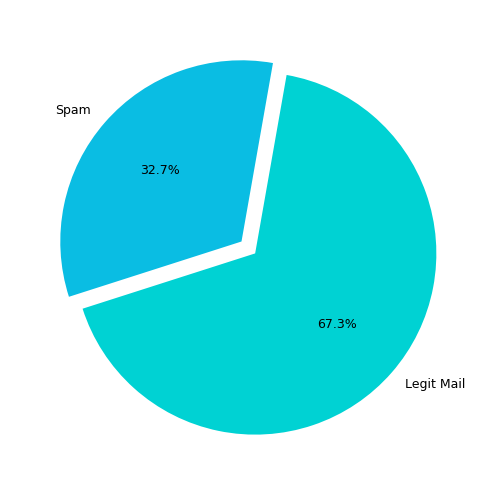

In [36]:
# visualize the email

category_list =['Spam','Legit Mail']
no_of_list =[no_of_spam, no_of_ham]
custom_color =['#0abde3','#00d2d3']

plt.figure(figsize=[4,4],dpi=150)
plt.pie(no_of_list, labels=category_list, textprops={'fontsize':6}, startangle=80, autopct= '%1.1f%%', colors=custom_color, explode=[0,0.1])
plt.show()

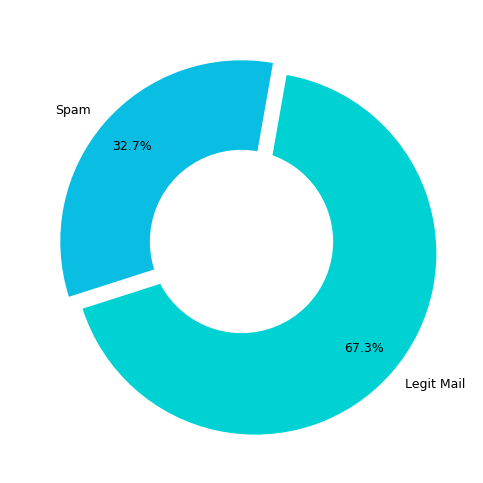

In [37]:
# visualize the email

category_list =['Spam','Legit Mail']
no_of_list =[no_of_spam, no_of_ham]
custom_color =['#0abde3','#00d2d3']

plt.figure(figsize=[4,4],dpi=150)
plt.pie(no_of_list, labels=category_list, textprops={'fontsize':6}, startangle=80,
        autopct= '%1.1f%%', colors=custom_color, explode=[0,0.1], pctdistance=0.8)

#draw circle

circle_center = plt.Circle((0,0), radius=0.5, color='white')
plt.gca().add_artist(circle_center)

plt.show()




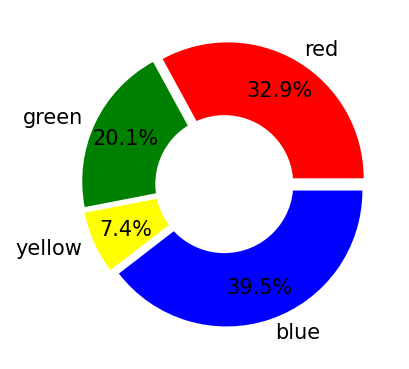

In [38]:
# let us create a donought chart with 4 categories

categories= ['red','green','yellow','blue']
no_of_colors =[200,122,45,240]
color_cat =['red','green','yellow','blue']

offset= [0.05,0.05,0.05,0.05]

plt.figure(figsize=(3,3), dpi=150)
plt.pie(no_of_colors,labels=categories, colors= color_cat, autopct='%1.1f%%', pctdistance=0.75, explode=offset)

circle = plt.Circle((0,0), radius=0.5, color='white')
plt.gca().add_artist(circle)
plt.show()

### Natural Language Processing
#### Text Pre-Processing

In [39]:
# convert to lower case
msg= 'All work and no play makes Jack a dull boy.'
msg.lower()



'all work and no play makes jack a dull boy.'

#### Download NLTK resources (Tokenizers, Stopwords)

In [40]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [41]:
msg= 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

In [0]:
### Removing StopWords

In [43]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
stop_words = set(stopwords.words('english'))

In [45]:
# download Novels

nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to /root/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

In [46]:
if 'this' in stop_words: print('found it!!')

found it!!


In [47]:
if 'hello' not in stop_words: print('Nope. Not there!')

Nope. Not there!


In [0]:
msg= 'All work and no play makes Jack a dull boy. To be or not to be'



In [49]:
words_tokenized = word_tokenize(msg.lower())
type(words_tokenized)

list

In [50]:
%%time

filtered_words =[]
i=0
for i in range(len(words_tokenized)):
  if words_tokenized[i] not in list(stop_words):
    filtered_words.append(words_tokenized[i])
    i+=1
  else:
    i+=1
    continue

filtered_words



CPU times: user 99 µs, sys: 19 µs, total: 118 µs
Wall time: 141 µs


In [51]:
%%time
filtered_words = []

for word in words_tokenized:
  if word not in stop_words:
    filtered_words.append(word)
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.']
CPU times: user 756 µs, sys: 0 ns, total: 756 µs
Wall time: 934 µs


### Words Stem and Stemming

In [52]:
msg= 'All work and no play makes Jack a dull boy. To be or not to be. Nobody expects the Spanish Inquisition!'

words_tokenized = word_tokenize(msg.lower())

filtered_words = []

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

for word in words_tokenized:
  if word not in stop_words:
    stem_word = stemmer.stem(word)
    filtered_words.append(stem_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


### Removing Punctuation

In [53]:
'h'.isalpha()

True

In [54]:
# returns true if it is an alphabet/character
'.'.isalpha()

False

In [55]:
msg= 'All work and no play makes Jack a dull boy. To be or not to be. Nobody expects the Spanish Inquisition!'

words_tokenized = word_tokenize(msg.lower())

filtered_words = []

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

for word in words_tokenized:
  if word not in stop_words:
    if word.isalpha():
      stem_word = stemmer.stem(word)
      filtered_words.append(stem_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


### Removing HTML tags from Email

In [56]:
data.MESSAGE[4]

'<html>\n\n<head>\n\n</head>\n\n<body>\n\n\n\n<center>\n\n<font face=3D"times" size=3D"6" color=3D"#000000">Save up to\n\n\n\n<font color=3D"#ff0000">75%</font> on your Term Life\n\nInsurance!</font>\n\n<br>  \n\n<font face=3D"times" size=3D"4" color=3D"#000000">\n\n<i>Compare rates from top insurance companies around\n\nthe country</i></font>\n\n<br><br>\n\n<font face=3D"arial" size=3D"4" color=3D"#7084D6">\n\n<b>In our life and times, it\'s important to plan for\n\nyour family\'s future, while \n\n<br>being comfortable financially.  Choose the right\n\nLife Insurance policy today.</font>\n\n<p>\n\n<font face=3D"arial" size=3D"3" color=3D"#000000">\n\n<i>Click the link below to compare the lowest rates\n\nand save up to <font\n\ncolor=3D"#ff0000">75%</font></i></b></font>  \n\n<p>\n\n<a\n\nhref=3D"http://insurancequotesource.com/user0202/termquotes/473400/"><font\n\nface=3D"arial"\n\nsize=3D"4">\n\n<b>COMPARE YOUR COVERAGE</b></font></a>\n\n<p>\n\n<font face=3D"times" size=3D"5" color

In [57]:
# using the at property to access the message at index 2

data.at[4,'MESSAGE']

'<html>\n\n<head>\n\n</head>\n\n<body>\n\n\n\n<center>\n\n<font face=3D"times" size=3D"6" color=3D"#000000">Save up to\n\n\n\n<font color=3D"#ff0000">75%</font> on your Term Life\n\nInsurance!</font>\n\n<br>  \n\n<font face=3D"times" size=3D"4" color=3D"#000000">\n\n<i>Compare rates from top insurance companies around\n\nthe country</i></font>\n\n<br><br>\n\n<font face=3D"arial" size=3D"4" color=3D"#7084D6">\n\n<b>In our life and times, it\'s important to plan for\n\nyour family\'s future, while \n\n<br>being comfortable financially.  Choose the right\n\nLife Insurance policy today.</font>\n\n<p>\n\n<font face=3D"arial" size=3D"3" color=3D"#000000">\n\n<i>Click the link below to compare the lowest rates\n\nand save up to <font\n\ncolor=3D"#ff0000">75%</font></i></b></font>  \n\n<p>\n\n<a\n\nhref=3D"http://insurancequotesource.com/user0202/termquotes/473400/"><font\n\nface=3D"arial"\n\nsize=3D"4">\n\n<b>COMPARE YOUR COVERAGE</b></font></a>\n\n<p>\n\n<font face=3D"times" size=3D"5" color

In [58]:
soup = BeautifulSoup(data.MESSAGE[4], 'html.parser')
print(soup.prettify())

<html>
 <head>
 </head>
 <body>
  <center>
   <font color='3D"#000000"' face='3D"times"' size='3D"6"'>
    Save up to
    <font color='3D"#ff0000"'>
     75%
    </font>
    on your Term Life

Insurance!
   </font>
   <br/>
   <font color='3D"#000000"' face='3D"times"' size='3D"4"'>
    <i>
     Compare rates from top insurance companies around

the country
    </i>
   </font>
   <br/>
   <br/>
   <font color='3D"#7084D6"' face='3D"arial"' size='3D"4"'>
    <b>
     In our life and times, it's important to plan for

your family's future, while
     <br/>
     being comfortable financially.  Choose the right

Life Insurance policy today.
    </b>
   </font>
   <p>
    <font color='3D"#000000"' face='3D"arial"' size='3D"3"'>
     <i>
      Click the link below to compare the lowest rates

and save up to
      <font color='3D"#ff0000"'>
       75%
      </font>
     </i>
    </font>
   </p>
  </center>
 </body>
</html>
<p>
 <a href='3D"http://insurancequotesource.com/user0202/termquotes/4

In [59]:
soup.get_text()

"\n\n\n\n\nSave up to\n\n\n\n75% on your Term Life\n\nInsurance!\n\n\nCompare rates from top insurance companies around\n\nthe country\n\n\nIn our life and times, it's important to plan for\n\nyour family's future, while \n\nbeing comfortable financially.  Choose the right\n\nLife Insurance policy today.\n\n\nClick the link below to compare the lowest rates\n\nand save up to 75%\n\n\nCOMPARE YOUR COVERAGE\n\n\n\nYou'll be able to compare rates and get a free\n\napplication in less than a minute!\n\n\n*Get your FREE instant quotes...\n\n*Compare the lowest prices, then...\n\n*Select a company and Apply Online.\n\n\nGET A FREE QUOTE NOW!\n\n\nYou can't predict the future, but you can always\n\nprepare for it.\n\n\nto be\n\nexcluded from future contacts \n\n\n\ntuckers\n\n\n\n\n\n\n\n\n\n\n"

### Functions for Email Processing

In [0]:
def clean_message(msg, stemmer=PorterStemmer(), stop_words= set(stopwords.words('english'))):

  word_list = []

  # converts to lowercase and splits up the individual words

  words = word_tokenize(msg.lower())

  for word in words:
    # removes stopwords and punctuations

    if word not in stop_words and word.isalpha():
      word_list.append(stemmer.stem(word))

  return word_list



In [61]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [0]:
# funciton to return clean text to clean out html tags as well

def clean_html_message(msg, stemmer=PorterStemmer(), stop_words= set(stopwords.words('english'))):

  word_list = []

  # remove html tags first
  soup = BeautifulSoup(msg,'html.parser')
  msg = soup.get_text()
  
  
  # converts to lowercase and splits up the individual words

  words = word_tokenize(msg.lower())

  for word in words:
    # removes stopwords and punctuations

    if word not in stop_words and word.isalpha():
      word_list.append(stemmer.stem(word))
    
  

  return word_list



In [63]:
# testing the above funtion with document id no 2

clean_html_message(data.at[4,'MESSAGE'])

['save',
 'term',
 'life',
 'insur',
 'compar',
 'rate',
 'top',
 'insur',
 'compani',
 'around',
 'countri',
 'life',
 'time',
 'import',
 'plan',
 'famili',
 'futur',
 'comfort',
 'financi',
 'choos',
 'right',
 'life',
 'insur',
 'polici',
 'today',
 'click',
 'link',
 'compar',
 'lowest',
 'rate',
 'save',
 'compar',
 'coverag',
 'abl',
 'compar',
 'rate',
 'get',
 'free',
 'applic',
 'less',
 'minut',
 'free',
 'instant',
 'quot',
 'lowest',
 'price',
 'compani',
 'appli',
 'onlin',
 'get',
 'free',
 'quot',
 'ca',
 'predict',
 'futur',
 'alway',
 'prepar',
 'exclud',
 'futur',
 'contact',
 'tucker']

In [64]:
type(data.at[4,'MESSAGE'])

str

### Apply Cleaning and Tokenization to all Messages

##### Slicing DataFrames and Series and Creating Subsets

In [65]:
data.iat[2,0] # accessing columns by the column number instead of  column name

'<TABLE borderColorDark=#0000cc width=700 align=center bgColor=#ffffff \n\nborderColorLight=#000000 border=2>\n\n<TBODY>\n\n<TR>\n\n<TD>\n\n<DIV align=center>\n\n<H3><B>Hot Tawnee the Internet Sensation is ready to bare all for \n\nyou.</B><BR><B>Looking at those <FONT color=#0000ff>firm tits and creamy soft \n\nthighs</FONT> you can\'t help but get an instant erection. Now Tawnee\'s Sister \n\nTori joined in. Both are sweet little honeys that love to show you what a good \n\ntime is all about!</B><BR>\n\n          <B>Click here To Visit <FONT size=2><A href="http://lightspeed.d2g.com"><font size="5" color="#FF0000">TawneeStone.com</font></A></FONT><FONT color=#000000> \n\n          where you will see both posing for you in many erotic ways</FONT></B> \n\n        </H3>\n\n      </DIV></TD></TR></TBODY></TABLE>\n\n\t  <p>&nbsp;</p><TABLE borderColorDark=#0000cc width=700 align=center bgColor=#ffffff \n\nborderColorLight=#000000 border=2>\n\n<TBODY>\n\n<TR>\n\n    <TD>\n\n      <div alig

In [0]:
# if we want to select subset/ say more than one row of dataframe instead we use iloc attribute

# iloc works on both dataframe and series

In [67]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
5,"\n\n<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4....",1,00290.eb053a191b7509a9399aa16717630414
6,------=_NextPart_000_00D7_08E60D5B.E5437E70\n\...,1,00078.6944f51ce9c0586d8f9137d2d2207df0
7,UNCOMMON EXOTIC PLEASURE BOTANICALS!\n\n\n\nFe...,1,00489.023c1d77de9365cad956a4c9118aee4b
8,This is a multi-part message in MIME format.\n...,1,00421.ca2fe949a956845a9ba81c649a7db6c0
9,"<STYLE type=""text/css"">\n\n<!--\n\nP{\n\n fon...",1,00500.85b72f09f6778a085dc8b6821965a76f
10,<HTML><HEAD><TITLE></TITLE><META http-equiv=3D...,1,00331.a61788d316e7393c8bbf8ee19b24c713


In [0]:
first_msg = data.MESSAGE.iloc[3:5]
nested_list = first_msg.apply(clean_message) #calling the clean_message function 
#type(first_msg.apply(clean_message))

In [69]:
flat_list = []
for sublist in nested_list: #going through all the list within the list, content of the message
  for items in sublist: # going through all the elements with each list i.e words within the list
    flat_list.append(items)

len(flat_list)

149

In [70]:
# using list comprehension to carry out the above task i.e nesting of loops

flat_list = [ items for sublist in nested_list for items in sublist]

len(flat_list)

149

In [71]:
%%time

# apply clean_html_message() on all the emails from the dataframe

nested_list = data.MESSAGE.apply(clean_html_message)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


CPU times: user 35.7 s, sys: 63.1 ms, total: 35.8 s
Wall time: 35.9 s


In [72]:
nested_list.tail()

5791    [tri, littl, problem, size, instal, redhat, di...
5792    [sun, jul, che, wrote, server, mention, work, ...
5793    [fri, aug, paul, linehan, wrote, way, mail, li...
5794    [hello, fork, whilst, digit, meander, around, ...
5795    [nev, dull, adam, shand, politech, date, thu, ...
Name: MESSAGE, dtype: object

### Using Logic to Slice DataFrame

In [73]:
data[data.CATEGORY==1].shape

(1896, 3)

In [74]:
data[data.CATEGORY==1].tail()

,MESSAGE,CATEGORY,FILE_NAME
1891,JetMp3 T=FCrkiye'de ilk kez uygulanan bir sist...,1,01045.21a9ee890753696f026212b3d25f28e6
1892,"DEAR SIR,\n\n\n\nI am MRS MARIAM ABACHA, wife ...",1,01011.d4812088cad8553fb214dab8003add9b
1893,"<div align=""center"">\n\n <center>\n\n <table...",1,00893.89d5fc38f24e7e2241888c19ec260994
1894,=3Chtml=3E=3Cbody \n\nonload=3D=22window=2Eope...,1,00811.1a510ce29a20ec57048d6b29d0056d57
1895,<HTML><HEAD><TITLE>Take Control Of Your Confer...,1,00586.6ffe1b192d01dc82c33e866ddabd2a79


In [0]:
doc_ids_spam = data[data.CATEGORY==1].index
doc_ids_ham = data[data.CATEGORY==0].index

### Subsetting a series with an index

In [0]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_ham = nested_list.loc[doc_ids_ham]

In [0]:
def most_frequent(List): 
    return max(set(List), key = List.count) 

In [78]:
ham_list_flat=[ word for lists in nested_list_ham for word in lists]

normal_words = pd.Series(ham_list_flat).value_counts()

normal_words.shape[0] #total number of unique words in non-spam messages


20744

In [79]:
# to get 10 most common words

normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [80]:
spam_list_flat=[ word for lists in nested_list_spam for word in lists]

spam_words = pd.Series(spam_list_flat).value_counts()

spam_words.shape[0] #total number of unique words in spam messages


13280

In [81]:
spam_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

In [82]:
total_words =[clean_html_message(word) for word in data.MESSAGE.values]


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [83]:
len(total_words)

5796

## Creating a WordCloud

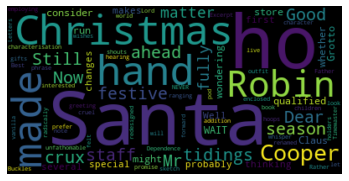

In [84]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [85]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [86]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [87]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [88]:

word_list = [''.join(word) for word in example_corpus]
word_list
novel_as_string = ' '.join(word_list)
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

In [89]:
# converting a list to string

x = ['1','2','4']
st = ' '.join(x)
st

'1 2 4'

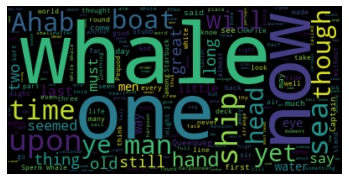

In [90]:
# creating word cloud for our novel moby-dick

word_cloud = WordCloud().generate(novel_as_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

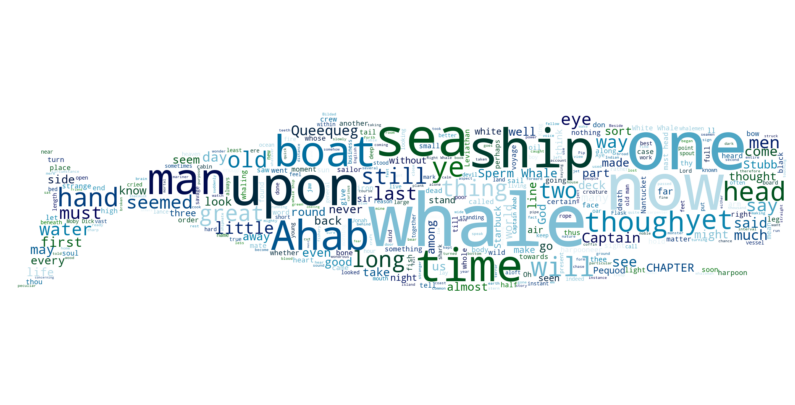

In [91]:
icon = Image.open(WHALE_PATH)
image_mask = Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)

rgb_array = np.array(image_mask) # converts an image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=400,
                       colormap='ocean').generate(novel_as_string)
plt.figure(figsize=[14,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [92]:
rgb_array.shape

(1024, 2048, 3)

In [93]:
rgb_array[100,255]

array([255, 255, 255], dtype=uint8)

In [94]:
rgb_array[500,2000]

array([0, 0, 0], dtype=uint8)

In [95]:
example_corpus = nltk.corpus.shakespeare.words('hamlet.xml')

word_list = [''.join(word) for word in example_corpus]
word_list
novel_as_string = ' '.join(word_list)
novel_as_string

"The Tragedy of Hamlet , Prince of Denmark Dramatis Personae CLAUDIUS , king of Denmark . HAMLET , son to the late , and nephew to the present king . POLONIUS , lord chamberlain . HORATIO , friend to Hamlet . LAERTES , son to Polonius . LUCIANUS , nephew to the king . VOLTIMAND CORNELIUS ROSENCRANTZ GUILDENSTERN OSRIC courtiers . A Gentleman A Priest . MARCELLUS BERNARDO officers . FRANCISCO , a soldier . REYNALDO , servant to Polonius . Players . Two Clowns , grave - diggers . FORTINBRAS , prince of Norway . A Captain . English Ambassadors . GERTRUDE , queen of Denmark , and mother to Hamlet . OPHELIA , daughter to Polonius . Lords , Ladies , Officers , Soldiers , Sailors , Messengers , and other Attendants . Ghost of Hamlet ' s Father . SCENE Denmark . HAMLET ACT I SCENE I . Elsinore . A platform before the castle . FRANCISCO at his post . Enter to him BERNARDO BERNARDO Who ' s there ? FRANCISCO Nay , answer me : stand , and unfold yourself . BERNARDO Long live the king ! FRANCISCO B

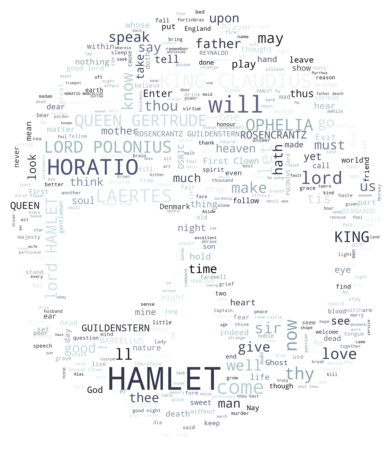

In [96]:
icon_2 = Image.open(SKULL_PATH)
image_mask_2 = Image.new(mode='RGB', size= icon_2.size, color='white')
image_mask_2.paste(icon_2, box=icon_2)

rgb_array = np.array(image_mask_2) # converts an image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=400,
                       colormap='bone').generate(novel_as_string)
plt.figure(figsize=[14,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Word Cloud of Ham and Spam Messages

In [97]:
# Creating Ham and Spam Content 

ham_content= ' '.join(ham_list_flat)
spam_content = ' '.join(spam_list_flat)
type(ham_content)

str

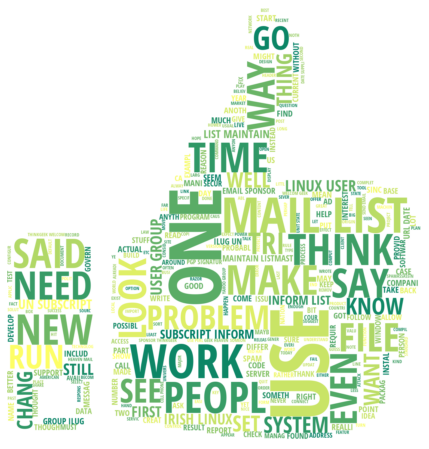

In [98]:
# Word Cloud for Ham Content
icon_2 = Image.open(HAM_PATH)
image_mask_2 = Image.new(mode='RGB', size= icon_2.size, color='white')
image_mask_2.paste(icon_2, box=icon_2)

rgb_array = np.array(image_mask_2) # converts an image object to an array

word_cloud = WordCloud(font_path= FONT_PATH_1, mask=rgb_array, max_font_size=300, background_color='white', max_words=300,
                       colormap='summer').generate(ham_content.upper())
plt.figure(figsize=[14,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

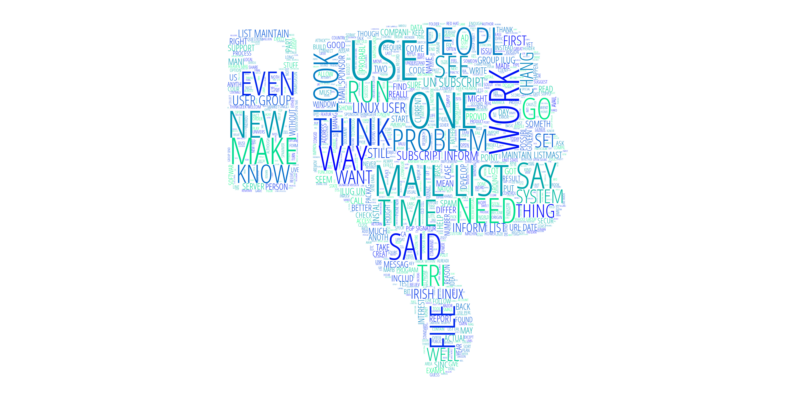

In [99]:
# Word Cloud for Spam Content

icon_2 = Image.open(SPAM_PATH)
image_mask_2 = Image.new(mode='RGB', size= icon_2.size, color='white')
image_mask_2.paste(icon_2, box=icon_2)

rgb_array = np.array(image_mask_2) # converts an image object to an array

word_cloud = WordCloud(font_path= FONT_PATH_2, mask=rgb_array, background_color='white', max_words=1000,
                       colormap='winter').generate(ham_content.upper())
plt.figure(figsize=[14,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Generate Vocabulary and Dictionary

In [100]:
stemmed_nested_list = data.MESSAGE.apply(clean_html_message)
flat_stemmed_list = [word for sublist in stemmed_nested_list for word in sublist]
#flat_stemmed_list

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [101]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('number of unique words: ', unique_words.shape[0])
unique_words.head() 

# although we have got 27294 unique words, we are going to train our classifier with onlt subset of this list

number of unique words:  27294


http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [102]:
# Creating a subset of series(unique_words) called freqent Words to store the top 2500 words 


frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words are : \n', frequent_words[0:10])

Most common words are : 
 http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


In [0]:
unique_list =[]
for word in unique_words.index:
  if word not in unique_list:
    unique_list.append(word)
  

In [104]:
frequent_new_list = unique_list[0:VOCAB_SIZE]
frequent_new_list

['http',
 'use',
 'list',
 'email',
 'get',
 'mail',
 'one',
 'free',
 'time',
 'work',
 'messag',
 'make',
 'like',
 'would',
 'peopl',
 'new',
 'inform',
 'receiv',
 'pleas',
 'click',
 'busi',
 'address',
 'want',
 'us',
 'need',
 'order',
 'remov',
 'also',
 'go',
 'year',
 'send',
 'money',
 'file',
 'compani',
 'system',
 'report',
 'way',
 'wrote',
 'name',
 'user',
 'look',
 'chang',
 'site',
 'day',
 'know',
 'state',
 'program',
 'may',
 'see',
 'call',
 'could',
 'group',
 'even',
 'think',
 'includ',
 'linux',
 'first',
 'offer',
 'take',
 'say',
 'right',
 'servic',
 'tri',
 'world',
 'help',
 'find',
 'internet',
 'market',
 'product',
 'mani',
 'much',
 'home',
 'said',
 'softwar',
 'web',
 'problem',
 'date',
 'line',
 'spam',
 'link',
 'check',
 'start',
 'number',
 'run',
 'good',
 'thing',
 'well',
 'subject',
 'interest',
 'phone',
 'govern',
 'person',
 'provid',
 'set',
 'today',
 'come',
 'million',
 'ad',
 'give',
 'server',
 'follow',
 'back',
 'best',
 'month'

### Create a Vocabulary DataFrame with a word_id

In [105]:
word_ids = list(range(0,VOCAB_SIZE))
vocab_df = pd.DataFrame({'vocab_words':frequent_words.index.values}, index=word_ids)
vocab_df.index.name = 'Word_id'
vocab_df.head()

,vocab_words
Word_id,
0,http
1,use
2,list
3,email
4,get


In [106]:
vocab_df.at[4,'vocab_words']

'get'

In [107]:
# getting index from the vocab_words

index_list = [word for word in vocab_df.vocab_words if word=='email']
print(index_list[0].index)

<built-in method index of str object at 0x7f9e32d720d8>


### Save the vocabulary as a csv file

In [0]:
vocab_df.to_csv(VOCAB_CSV_PATH, index_label =vocab_df.index.name, header= vocab_df.vocab_words.name)

In [109]:
emails_coll = [clean_html_message(msg) for msg in data.MESSAGE]

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [110]:
## this is for the entire email, but instead have to do for the emails stored the dataframe i.e 2500 emails

length = 0
i=0
for email in emails_coll:
  if len(email) > length:
    length = len(email)
    index =i

  i=i+1

print('the email with longest words count is: ', length)
print('and the index of the email is: ', index)

the email with longest words count is:  7661
and the index of the email is:  4791


In [111]:
# checking if the index position actually has the longest count of words

len(emails_coll[5487])

111

In [0]:
# to get the content of the email 

email_cont = emails_coll[index]
email_cont

In [113]:
# Pulling out Original Email form the dataframe

data.at[index,'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

In [0]:
#Tutorial way of solving the same problem

length_list = [] # to store the length of all the emails 

for email in emails_coll:
  length_list.append(len(email))


In [115]:
# to get the index position and the actual length we make the use of max and argmax funciton form the numpy

print(f'email that has the maximum length has index postion {np.argmax(length_list)} and total length is: {max(length_list)}')

email that has the maximum length has index postion 4791 and total length is: 7661


In [0]:
# using list comprehension as option

length_list = [len(email) for email in emails_coll]

In [0]:
# to access the content of that email 

emails_coll[np.argmax(length_list)]

In [118]:
# alternative to above to access from the dataframe is: 

data.at[np.argmax(length_list),'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

## Generate Features and a Sparse Matrix
### Creating a dataframe with one word per column

In [119]:
stemmed_nested_list

#this is a Series containing list, but let us convert it into list containing list using tolist()
# because it is easier to convert into dataframe

type(stemmed_nested_list.tolist())


list

In [0]:
stemmed_nested_list.tolist()

In [0]:
word_column_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())

In [122]:
word_column_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7621,7622,7623,7624,7625,7626,7627,7628,7629,7630,7631,7632,7633,7634,7635,7636,7637,7638,7639,7640,7641,7642,7643,7644,7645,7646,7647,7648,7649,7650,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660
0,messag,mime,format,mean,made,usa,cna,hit,road,tell,ingenu,innov,product,gutsi,spirit,encourag,attend,cna,american,road,show,get,insid,glimps,cna,new,product,revolutionari,care,innov,annuiti,new,cna,term,domin,market,cna,manag,also,share,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,dear,partner,first,must,apologis,use,medium,commun,project,highli,place,offici,govern,nigeria,also,found,member,rule,parti,power,peopl,democrat,parti,pdp,committe,niger,delta,develop,corpor,nddc,charg,manag,supervis,disburs,oil,sale,revenu,nigerian,revenu,control,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,hot,tawne,internet,sensat,readi,bare,firm,tit,creami,soft,thigh,ca,help,get,instant,erect,tawne,sister,tori,join,sweet,littl,honey,love,show,good,time,click,visit,see,pose,mani,erot,way,email,sent,unsolicit,subscrib,receiv,mail,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,interest,rate,cut,perfect,time,think,refinanc,home,mortgag,rate,take,minut,fill,quick,onlin,form,http,easi,qualifi,prompt,courteou,servic,low,rate,wait,interest,rate,go,lock,low,rate,unsubscrib,go,http,pleas,allow,hour,remov,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,save,term,life,insur,compar,rate,top,insur,compani,around,countri,life,time,import,plan,famili,futur,comfort,financi,choos,right,life,insur,polici,today,click,link,compar,lowest,rate,save,compar,coverag,abl,compar,rate,get,free,applic,less,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [123]:
word_column_df.shape # rows-> no, of emails we have in our dataframe and #column-> longest list of words we have

(5796, 7661)

In [0]:
data.index.name ='DOCUMENT_ID'

### Splitting the data into training and testing dataset


In [0]:
X_train, X_test, y_train, y_test = train_test_split(word_column_df, data.CATEGORY, test_size=0.3, random_state=42)

In [126]:
print('No of training sample: ', X_train.shape[0])
print('fraction of the training shape is: ',X_train.shape[0]/word_column_df.shape[0])

No of training sample:  4057
fraction of the training shape is:  0.6999654934437544


In [127]:
X_train.index.name = X_test.index.name= 'DOCUMENT_ID'
X_train.head()
y_train.head()

DOCUMENT_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

In [128]:
# Order of X_train and y_train should be same.

X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7621,7622,7623,7624,7625,7626,7627,7628,7629,7630,7631,7632,7633,7634,7635,7636,7637,7638,7639,7640,7641,7642,7643,7644,7645,7646,7647,7648,7649,7650,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660
DOCUMENT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4675,eugen,leitl,said,spammer,bother,keep,track,individu,whitelist,associ,given,email,address,good,bet,jm,jm,whitelist,cours,popul,whitelist,content,inbox,minu,spam,add,manual,stuff,addressbook,read,manual,j,mason,url,blog,http,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4220,hi,folk,tri,set,button,call,automat,forward,mail,use,mycomp,without,go,editor,far,got,right,recip,current,spam,spamcomp,msg,also,tri,seditsend,draft,forward,command,forward,spam,address,filter,get,adjust,delet,without,produc,edit,window,help,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2484,main,window,key,put,chang,folder,mode,first,time,use,start,exmh,hit,second,go,set,target,mode,type,charact,folder,name,hit,space,autocomplet,finish,keep,hit,space,loop,thru,folder,match,charact,type,hit,return,actual,select,folder,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2418,inn,share,wrote,hi,anyon,know,list,biggest,file,root,directori,second,biggest,want,find,reason,caus,root,full,system,solari,sparc,thank,think,everybodi,version,case,test,linux,find,f,l,xarg,du,sort,grep,pádraig,irish,linux,user,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5110,sun,jul,kevin,lyda,mention,tutori,thank,donnacha,sinc,apach,person,got,part,way,step,step,cd,wget,http,gunzip,apx,thank,kevin,termin,lazi,kate,irish,linux,user,group,ilug,http,un,subscript,inform,list,maintain,listmast,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [129]:
y_test.head()

DOCUMENT_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data 

In [130]:
word_index = pd.Index(vocab_df.vocab_words)

type(word_index[3])

str

In [131]:
word_index.get_loc('thu')

396

In [132]:
X_train.shape[0]

4057

In [0]:
def make_sparse_matrix(df,indexed_words, label):
  '''
  Returns sparse matrix as dataframe

  df: A dataframe with words in the column with a document ID as an index (X_train or X_test)

  indexed_words: index of words ordered by word id

  labels: Categories as a label (y_train or y_test)
  '''

  n_rows = df.shape[0]
  n_cols = df.shape[1]
  word_set = set(indexed_words)
  dict_list = []

  for i in range(n_rows):
    for j in range(n_cols):

      word = df.iat[i,j]
      if word in word_set:
        doc_id = df.index[i]
        word_id = indexed_words.get_loc(word) 
        category = label.at[doc_id]

        item ={'LABEL': category , 'OCCURENCE': 1, 'DOCUMENT_ID': doc_id,
               'WORD_ID': word_id}
        
        dict_list.append(item)
      
  return pd.DataFrame(dict_list)
              


In [134]:
%%time

sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 2min 59s, sys: 225 ms, total: 2min 59s
Wall time: 3min


In [135]:
sparse_train_df

,LABEL,OCCURENCE,DOCUMENT_ID,WORD_ID
0,0,1,4844,76
1,0,1,4844,543
2,0,1,4844,494
3,0,1,4844,100
4,0,1,4844,885
...,...,...,...,...
439930,1,1,860,1
439931,1,1,860,26
439932,1,1,860,487
439933,1,1,860,2


### Combine Occurences with Pandas groupby() method.

In [137]:
#grouping the training data

train_grouped = sparse_train_df.groupby(['DOCUMENT_ID','WORD_ID','LABEL']).sum()
train_grouped.head()

OCCURENCE
DOCUMENT_ID WORD_ID LABEL           
0           0       1              6
            1       1              2
            2       1              2
            4       1              2
            5       1              4

In [142]:
vocab_df.at[0,'vocab_words']

'http'

In [0]:
print(data.MESSAGE[0])

In [144]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,index,DOCUMENT_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,0,1,6
1,1,0,1,1,2
2,2,0,2,1,2
3,3,0,4,1,2
4,4,0,5,1,4


In [145]:
train_grouped.tail()

,index,DOCUMENT_ID,WORD_ID,LABEL,OCCURENCE
259357,259357,5795,1836,0,1
259358,259358,5795,2094,0,1
259359,259359,5795,2105,0,2
259360,259360,5795,2142,0,1
259361,259361,5795,2168,0,1


In [152]:
vocab_df.at[2105,'vocab_words']

'lawsuit'

In [0]:
print(data.iloc[5795,0])

In [154]:
train_grouped.shape

(259362, 5)

### Save Training Data as .txt File

In [0]:
np.savetxt(TRAIN_DATA_PATH, train_grouped, fmt='%d')

In [159]:
train_grouped.columns

Index(['index', 'DOCUMENT_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [0]:
# calling the function to make a sparse matrix for test Dataset

sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

In [179]:
test_grouped = sparse_test_df.groupby(['DOCUMENT_ID','WORD_ID','LABEL']).sum().reset_index()
test_grouped.head()

,DOCUMENT_ID,WORD_ID,LABEL,OCCURENCE
0,8,3,1,1
1,8,5,1,1
2,8,7,1,1
3,8,10,1,1
4,8,17,1,2


In [189]:
# email in test_grouped

len(test_grouped.DOCUMENT_ID.unique())

1714

In [195]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7621,7622,7623,7624,7625,7626,7627,7628,7629,7630,7631,7632,7633,7634,7635,7636,7637,7638,7639,7640,7641,7642,7643,7644,7645,7646,7647,7648,7649,7650,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660
DOCUMENT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4675,eugen,leitl,said,spammer,bother,keep,track,individu,whitelist,associ,given,email,address,good,bet,jm,jm,whitelist,cours,popul,whitelist,content,inbox,minu,spam,add,manual,stuff,addressbook,read,manual,j,mason,url,blog,http,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4220,hi,folk,tri,set,button,call,automat,forward,mail,use,mycomp,without,go,editor,far,got,right,recip,current,spam,spamcomp,msg,also,tri,seditsend,draft,forward,command,forward,spam,address,filter,get,adjust,delet,without,produc,edit,window,help,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2484,main,window,key,put,chang,folder,mode,first,time,use,start,exmh,hit,second,go,set,target,mode,type,charact,folder,name,hit,space,autocomplet,finish,keep,hit,space,loop,thru,folder,match,charact,type,hit,return,actual,select,folder,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2418,inn,share,wrote,hi,anyon,know,list,biggest,file,root,directori,second,biggest,want,find,reason,caus,root,full,system,solari,sparc,thank,think,everybodi,version,case,test,linux,find,f,l,xarg,du,sort,grep,pádraig,irish,linux,user,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5110,sun,jul,kevin,lyda,mention,tutori,thank,donnacha,sinc,apach,person,got,part,way,step,step,cd,wget,http,gunzip,apx,thank,kevin,termin,lazi,kate,irish,linux,user,group,ilug,http,un,subscript,inform,list,maintain,listmast,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [196]:
# email in X_test

len(X_test.index.unique())



1739

In [0]:
# sense checking

print(data.iat[8,0])

In [181]:
vocab_df.at[17,'vocab_words']

'receiv'

### Saving the test data to .txt format

In [0]:
np.savetxt(TEST_DATA_PATH, test_grouped, fmt='%d')

In [0]:
train_doc_ids = set(train_grouped.DOCUMENT_ID)
test_doc_ids = set(test_grouped.DOCUMENT_ID)

In [199]:
len(train_doc_ids)


4025

In [200]:
len(test_doc_ids)

1714

In [207]:
set(X_test.index.values) - test_doc_ids

{12,
 71,
 84,
 109,
 132,
 139,
 245,
 287,
 332,
 334,
 354,
 373,
 410,
 538,
 564,
 720,
 737,
 887,
 1001,
 1087,
 1293,
 1323,
 1507,
 1550,
 1786}

In [209]:
print(data.MESSAGE[1001])

------=_NextPart_000_00B0_58C75D0E.A4523D08

Content-Type: text/html; charset="iso-8859-1"

Content-Transfer-Encoding: base64





PCEtLSBzYXZlZCBmcm9tIHVybD0oMDAyMilodHRwOi8vaW50ZXJuZXQuZS1t

YWlsIC0tPg0KPGh0bWw+DQo8Ym9keT4NCjxwIGFsaWduPSJsZWZ0Ij48Yj48

Zm9udCBjb2xvcj0iIzAwODAwMCIgc2l6ZT0iNiI+UmVGaW5hbmNlIGFuZCBS

ZWR1Y2UgTW9udGhseSBQYXltZW50czwvZm9udD48L2I+PC9wPg0KPHAgYWxp

Z249ImxlZnQiPjxmb250IHNpemU9IjUiPjxiPjxmb250IGNvbG9yPSIjMDAw

MEZGIj5DT05TT0xJREFURSBERUJUIE9SIFJFRklOQU5DRSBZT1VSIEhPTUUh

PC9mb250Pjxicj4NCjxmb250IGNvbG9yPSIjRkYwMDAwIj4gICAgICAgICAg

IEF0IFRoZSBMb3dlc3QgTW9ydGdhZ2UgQ29zdCBBbmQgUmF0ZSE8L2ZvbnQ+

PC9iPjwvZm9udD48L3A+DQo8cCBhbGlnbj0ibGVmdCI+PGI+PHNwYW4gc3R5

bGU9ImZvbnQtZmFtaWx5OiBUaW1lcyBOZXcgUm9tYW47IG1zby1mYXJlYXN0

LWZvbnQtZmFtaWx5OiBUaW1lcyBOZXcgUm9tYW47IG1zby1hbnNpLWxhbmd1

YWdlOiBFTi1VUzsgbXNvLWZhcmVhc3QtbGFuZ3VhZ2U6IEVOLVVTOyBtc28t

YmlkaS1sYW5ndWFnZTogQVItU0EiPjxmb250IHNpemU9IjQiIGNvbG9yPSIj

MDAwMDAwIj5Zb3UgY291bGQgZ2V0IENBU0ggQkFDSyB3aXRoaW4gMjQgaG91

c

In [210]:
data.loc[12]

MESSAGE      ------=_NextPart_000_00E4_17A73C2D.E7104E07\n\...
CATEGORY                                                     1
FILE_NAME               00303.22239f1393297a691eb5df3dfe7a5001
Name: 12, dtype: object

In [211]:
clean_html_message(data.at[12,'MESSAGE'])

['kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysr',
 'kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysr']